In [1]:
import pandas as pd

fire_alg = pd.read_csv("./DATA/firedataset/viirs-jpss1_2024_Algeria.csv")
fire_tun = pd.read_csv("./DATA/firedataset/viirs-jpss1_2024_Tunisia.csv")

fire_all = pd.concat([fire_alg, fire_tun], ignore_index=True)
print(fire_all.shape)
fire_all.head()


(90250, 15)


,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type
0,27.72818,9.87200,295.51,0.76,0.77,2024-01-01,3,N20,VIIRS,n,2,277.66,1.24,N,2
1,28.63288,9.77909,301.80,0.79,0.78,2024-01-01,3,N20,VIIRS,n,2,277.05,1.57,N,2
2,28.64012,9.77953,298.65,0.79,0.78,2024-01-01,3,N20,VIIRS,n,2,277.04,1.34,N,2
3,36.74886,6.25409,338.04,0.46,0.39,2024-01-01,141,N20,VIIRS,n,2,257.28,5.21,N,2
4,35.87978,4.44782,309.49,0.41,0.37,2024-01-01,141,N20,VIIRS,n,2,272.08,1.58,N,2


Génération de la carte de l'Algérie...


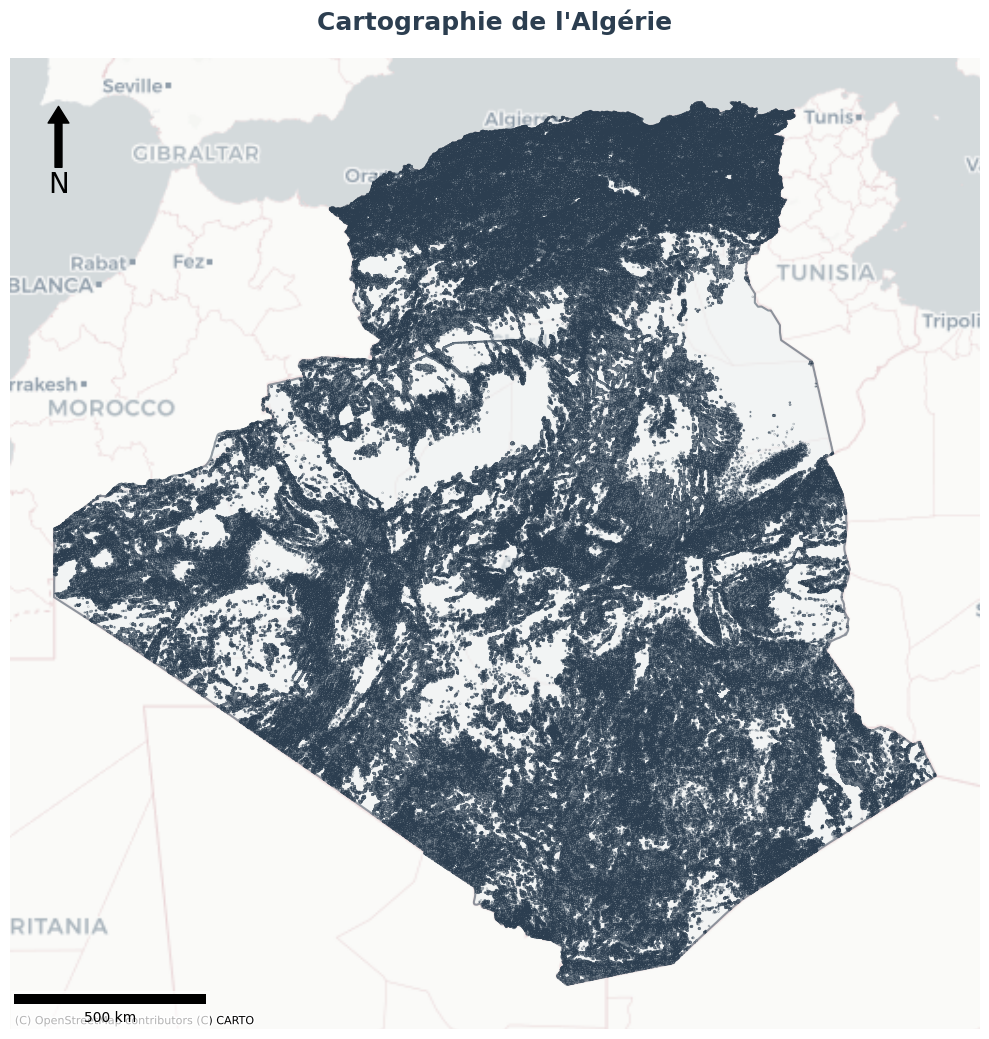

Génération de la carte de la Tunisie...


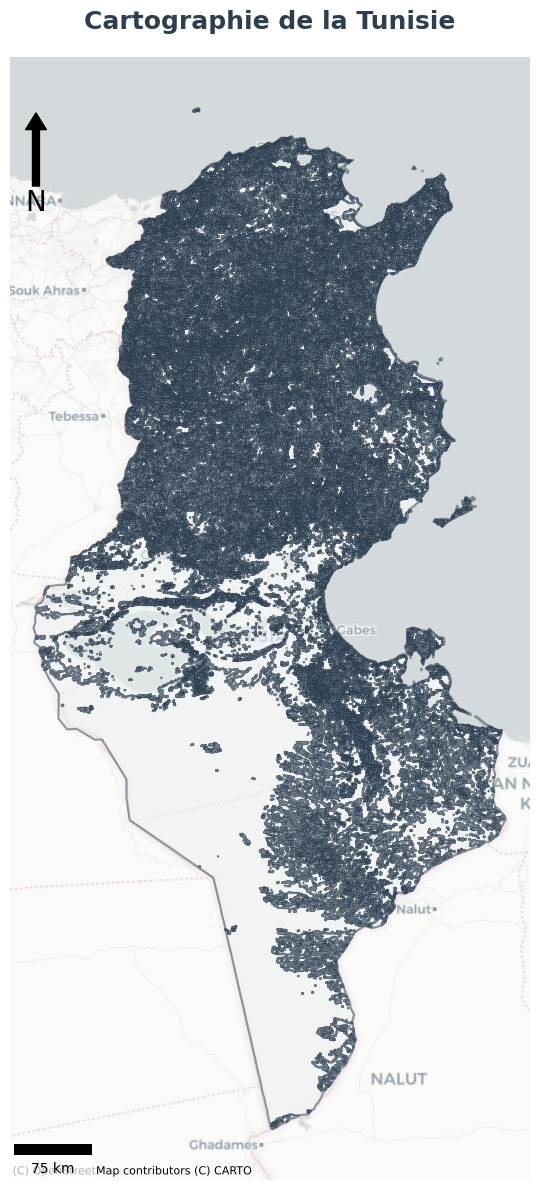

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Point

def plot_beautiful_map(shp_path, title, output_name):
    # 1. Chargement des données
    gdf = gpd.read_file(shp_path)
    
    # 2. Projection : Contextily nécessite du Web Mercator (EPSG:3857)
    # On projette pour que le fond de carte s'aligne parfaitement
    gdf = gdf.to_crs(epsg=3857)
    
    # 3. Création de la figure
    fig, ax = plt.subplots(figsize=(10, 12))
    
    # 4. Affichage du Shapefile
    # Facecolor avec alpha pour voir le fond de carte par transparence
    gdf.plot(ax=ax, edgecolor='#2c3e50', facecolor='#ecf0f1', linewidth=1.5, alpha=0.5)
    
    # 5. Ajout du fond de carte (Basemap)
    # Sources possibles : ctx.providers.OpenStreetMap.Mapnik, ctx.providers.Stamen.Terrain
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    
    # 6. Ajout de la barre d'échelle
    # On récupère la distance en mètres (puisque EPSG:3857 est en mètres)
    ax.add_artist(ScaleBar(1, location='lower left', box_alpha=0.7))
    
    # 7. Ajout d'une flèche du Nord (Custom)
    x, y, arrow_length = 0.05, 0.95, 0.08
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=20, xycoords='axes fraction')

    # 8. Nettoyage de l'interface
    ax.set_title(title, fontsize=18, fontweight='bold', pad=20, color='#2c3e50')
    ax.set_axis_off() # On enlève les coordonnées de bordure pour un look "print"
    
    # 9. Sauvegarde et affichage
    plt.tight_layout()
    plt.savefig(f"{output_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

# --- Exécution pour l'Algérie ---
print("Génération de la carte de l'Algérie...")
plot_beautiful_map("./DATA/shapefile/dza_gc_adg.shp", "Cartographie de l'Algérie", "Algerie_Admin")

# --- Exécution pour la Tunisie ---
print("Génération de la carte de la Tunisie...")
plot_beautiful_map("./DATA/shapefile/tun_gc_adg.shp", "Cartographie de la Tunisie", "Tunisie_Admin")

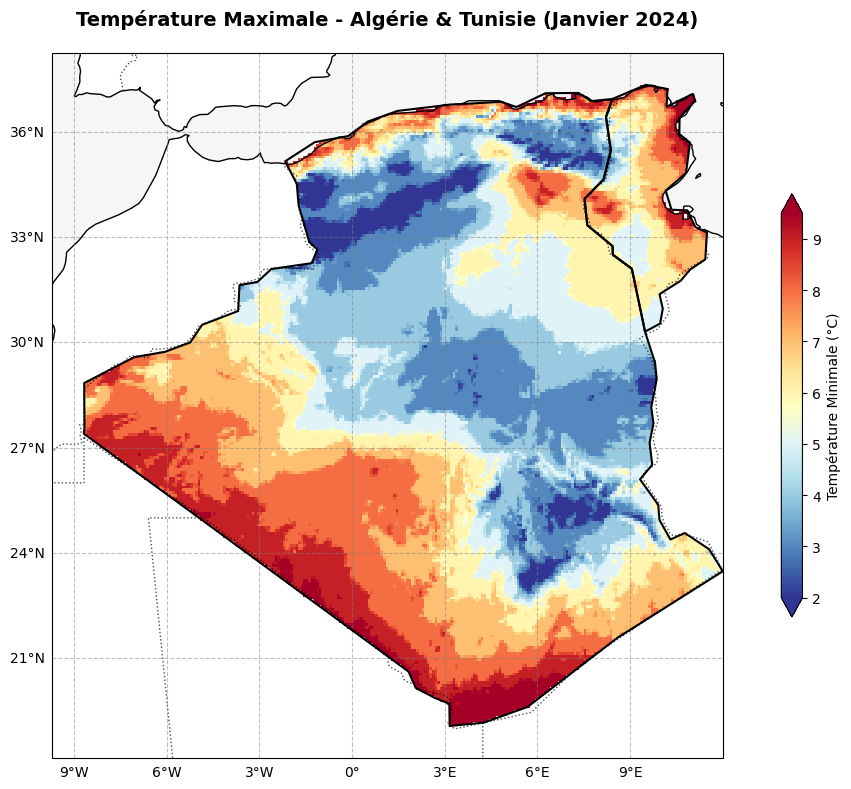

In [ ]:
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# 1. Chargement des données
fp = "DATA/Climate/Tmin/wc2.1_cruts4.09_5m_tmin_2024-01.tif"
da = rxr.open_rasterio(fp).squeeze(drop=True)

# 2. Préparation des frontières (Algérie + Tunisie)
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip")
at = world[world["ISO_A3"].isin(["DZA","TUN"])].to_crs(da.rio.crs)

# 3. Découpage (Clip)
da_clip = da.rio.clip(at.geometry, at.crs, drop=True)

# 4. Création de la figure (Un seul axe)
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# 5. Affichage du Raster
# Utilisation de 'RdYlBu_r' (Rouge pour chaud, Bleu pour froid)
im = da_clip.plot(
    ax=ax, 
    transform=ccrs.PlateCarree(), 
    cmap="RdYlBu_r", 
    robust=True, 
    add_colorbar=True,
    cbar_kwargs={
        'location': 'right',
        'shrink': 0.6,          # Réduit la taille de la barre
        'pad': 0.05,            # Espace entre la carte et la barre
        'label': 'Température Minimale (°C)'
    }
)

# 6. Ajout des détails cartographiques
at.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.5, zorder=3)
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.7)
ax.add_feature(cfeature.OCEAN, facecolor='lightgrey', alpha=0.2) # Pour distinguer la mer

# 7. Configuration des lignes de grille (Latitude/Longitude)
gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gl.top_labels = False   # Enlever les étiquettes en haut
gl.right_labels = False # Enlever les étiquettes à droite
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# 8. Titre et mise en page
plt.title("Température Minimale - Algérie & Tunisie (Janvier 2024)", 
          fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig("Tmin_Algerie_Tunisie.png", dpi=300, bbox_inches='tight')
plt.show()

c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


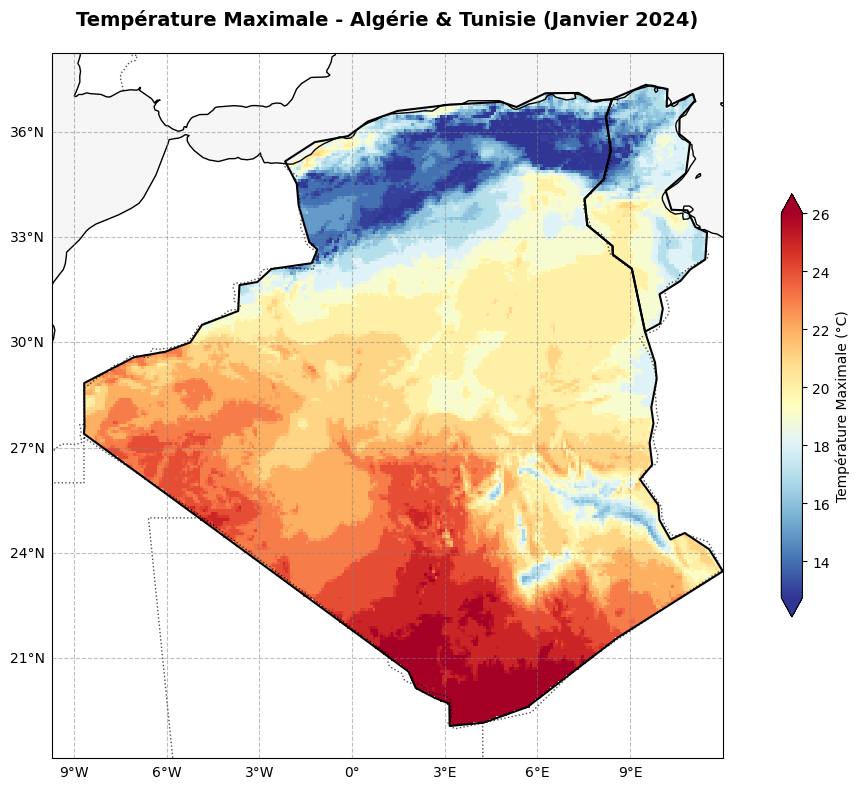

In [8]:
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# 1. Chargement des données
fp = "DATA/Climate/Tmax/wc2.1_cruts4.09_5m_tmax_2024-01.tif"
da = rxr.open_rasterio(fp).squeeze(drop=True)

# 2. Préparation des frontières (Algérie + Tunisie)
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip")
at = world[world["ISO_A3"].isin(["DZA","TUN"])].to_crs(da.rio.crs)

# 3. Découpage (Clip)
da_clip = da.rio.clip(at.geometry, at.crs, drop=True)

# 4. Création de la figure (Un seul axe)
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# 5. Affichage du Raster
# Utilisation de 'RdYlBu_r' (Rouge pour chaud, Bleu pour froid)
im = da_clip.plot(
    ax=ax, 
    transform=ccrs.PlateCarree(), 
    cmap="RdYlBu_r", 
    robust=True, 
    add_colorbar=True,
    cbar_kwargs={
        'location': 'right',
        'shrink': 0.6,          # Réduit la taille de la barre
        'pad': 0.05,            # Espace entre la carte et la barre
        'label': 'Température Maximale (°C)'
    }
)

# 6. Ajout des détails cartographiques
at.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.5, zorder=3)
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.7)
ax.add_feature(cfeature.OCEAN, facecolor='lightgrey', alpha=0.2) # Pour distinguer la mer

# 7. Configuration des lignes de grille (Latitude/Longitude)
gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gl.top_labels = False   # Enlever les étiquettes en haut
gl.right_labels = False # Enlever les étiquettes à droite
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# 8. Titre et mise en page
plt.title("Température Maximale - Algérie & Tunisie (Janvier 2024)", 
          fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig("Tmax_Algerie_Tunisie.png", dpi=300, bbox_inches='tight')
plt.show()

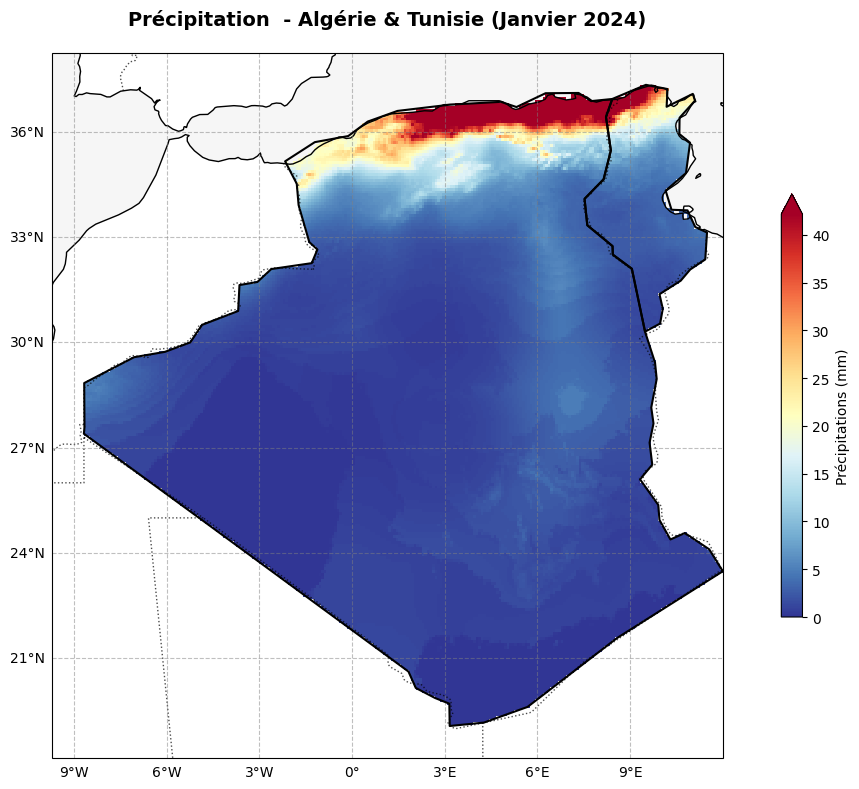

In [11]:
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# 1. Chargement des données
fp = "DATA/Climate/prec/wc2.1_cruts4.09_5m_prec_2024-01.tif"
da = rxr.open_rasterio(fp).squeeze(drop=True)

# 2. Préparation des frontières (Algérie + Tunisie)
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip")
at = world[world["ISO_A3"].isin(["DZA","TUN"])].to_crs(da.rio.crs)

# 3. Découpage (Clip)
da_clip = da.rio.clip(at.geometry, at.crs, drop=True)

# 4. Création de la figure (Un seul axe)
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# 5. Affichage du Raster
# Utilisation de 'RdYlBu_r' (Rouge pour chaud, Bleu pour froid)
im = da_clip.plot(
    ax=ax, 
    transform=ccrs.PlateCarree(), 
    cmap="RdYlBu_r", 
    robust=True, 
    add_colorbar=True,
    cbar_kwargs={
        'location': 'right',
        'shrink': 0.6,          # Réduit la taille de la barre
        'pad': 0.05,            # Espace entre la carte et la barre
        'label': 'Précipitations (mm)'
    }
)

# 6. Ajout des détails cartographiques
at.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.5, zorder=3)
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.7)
ax.add_feature(cfeature.OCEAN, facecolor='lightgrey', alpha=0.2) # Pour distinguer la mer

# 7. Configuration des lignes de grille (Latitude/Longitude)
gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gl.top_labels = False   # Enlever les étiquettes en haut
gl.right_labels = False # Enlever les étiquettes à droite
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# 8. Titre et mise en page
plt.title("Précipitation  - Algérie & Tunisie (Janvier 2024)", 
          fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig("Prec_Algerie_Tunisie.png", dpi=300, bbox_inches='tight')
plt.show()

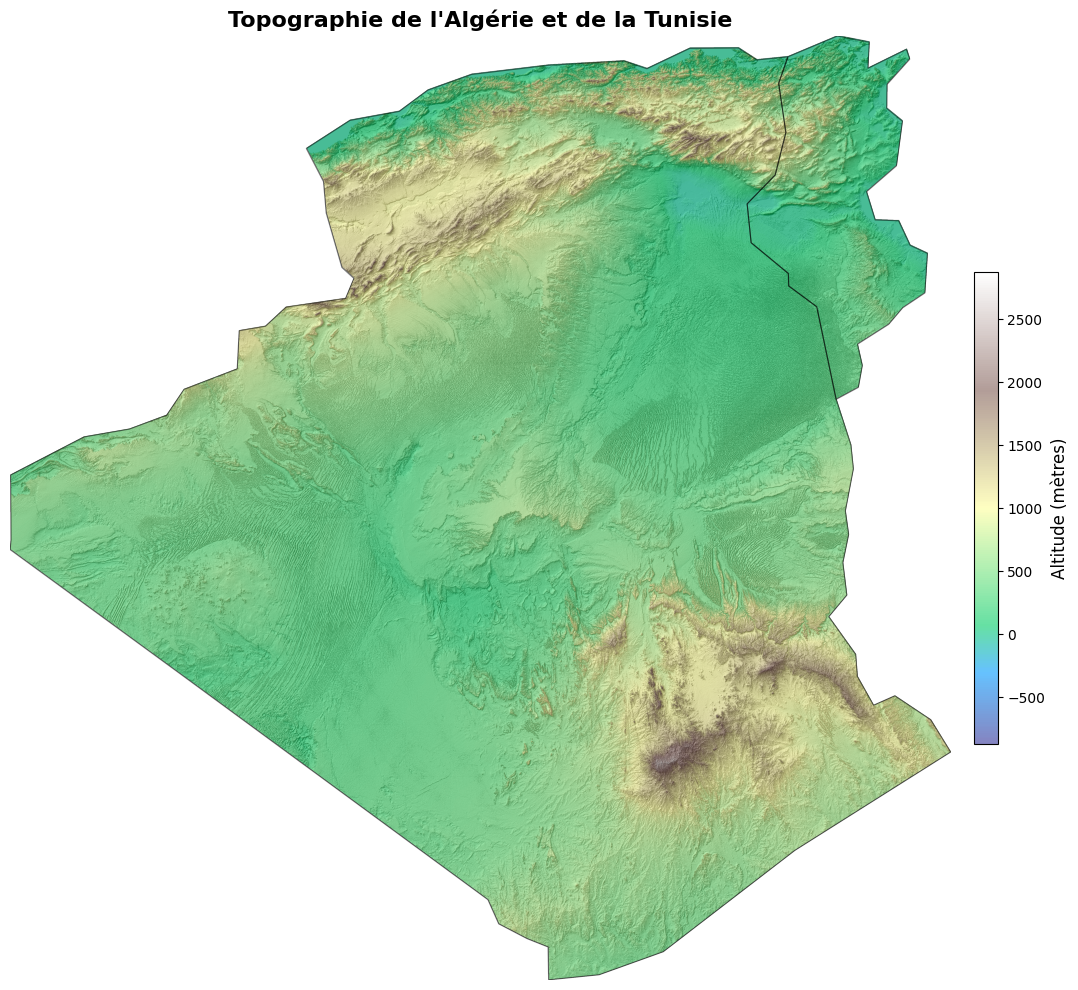

In [12]:
import rasterio
import rasterio.mask
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LightSource

# 1. Chargement des frontières pour le découpage (Clip)
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip")
at = world[world["ISO_A3"].isin(["DZA", "TUN"])]

# 2. Ouverture et découpage du Raster
path = "DATA/Elevation/be15_grd/w001001.adf"

with rasterio.open(path) as src:
    # On s'assure que le shapefile est dans le même CRS que le raster
    at = at.to_crs(src.crs)
    
    # Découpage (Mask) du raster selon les frontières
    out_image, out_transform = rasterio.mask.mask(src, at.geometry, crop=True)
    out_image = out_image[0]  # On récupère la première bande
    
    # Remplacer les valeurs de "NoData" par NaN pour l'affichage
    out_image = np.where(out_image == src.nodata, np.nan, out_image)

# 3. Création de l'effet de relief (Hillshade)
ls = LightSource(azdeg=315, altdeg=45) # Source de lumière venant du Nord-Ouest
hillshade = ls.hillshade(out_image, vert_exag=0.1)

# 4. Affichage esthétique
fig, ax = plt.subplots(figsize=(12, 10))

# Affichage du relief ombré
ax.imshow(hillshade, cmap='gray', extent=[
    out_transform[2], out_transform[2] + out_transform[0] * out_image.shape[1],
    out_transform[5] + out_transform[4] * out_image.shape[0], out_transform[5]
])

# Superposition de la couleur (Colormap terrain) avec transparence
im = ax.imshow(out_image, cmap='terrain', alpha=0.6, extent=[
    out_transform[2], out_transform[2] + out_transform[0] * out_image.shape[1],
    out_transform[5] + out_transform[4] * out_image.shape[0], out_transform[5]
])

# 5. Personnalisation
at.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.8, alpha=0.5)
ax.set_title("Topographie de l'Algérie et de la Tunisie", fontsize=16, fontweight='bold')
ax.set_axis_off()

# Barre de couleur élégante
cbar = fig.colorbar(im, ax=ax, shrink=0.5, pad=0.02)
cbar.set_label("Altitude (mètres)", fontsize=12)

plt.tight_layout()
plt.show()